In [396]:
def classify_sources(visit, filter, sigma, ccd, datadir):
        
        import DiaSourceTools as DSTools
        import DCTools
        import lsst.afw.geom as afwGeom
        import lsst.afw.table as afwTable
        import lsst.daf.base as dafBase
        
    
        
        
        from lsst.ip.diffim import ImagePsfMatchTask, DipoleMeasurementTask
        
        import lsst.daf.persistence as dafPersist
        
        butler = dafPersist.Butler(datadir+"/output")

        algMetadata = dafBase.PropertyList()
        schema = afwTable.SourceTable.makeMinimalSchema()
        dipoleMeasurement = DipoleMeasurementTask

        config = dipoleMeasurement.ConfigClass()
        dipoleMeasurement = dipoleMeasurement(schema, algMetadata=algMetadata)
        
        source_catalog = None
        classification = []

        if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':filter , 'ccd':ccd}):

                diffExp = butler.get("deepDiff_differenceExp", {'visit': visit , 'filter':filter , 'ccd':ccd})
                try:
                            results = DSTools.detect_diasources(diffExp, doSmooth=False, threshold=sigma)
                            diaSources =  DCTools.merge_sources(results, schema, algMetadata)
                            dipoleMeasurement.run(diaSources, diffExp)
                            print diaSources
                            source_catalog = DCTools.remove_nan_sources(diaSources)                
                            
                except Exception, e:
                            print "exception"
                            print e
                        
        if source_catalog is None:
            return [str(visit)+"-"+str(ccd)]
       
        img_label = str(visit)+"-"+str(ccd)
        for source in source_catalog:
            
            bbox = diffExp.getBBox()
            wcs = diffExp.getWcs()
            
            center = afwGeom.Point2I(wcs.skyToPixel(source.getRa(), source.getDec()))
            
                  
            stamp = DSTools.get_stamp(source, diffExp, offset=10)
            
        
            if stamp is not None:
                stamp_clone = stamp.clone()
                results = DSTools.detect_diasources(stamp_clone, doSmooth=False,threshold=sigma)


                if len(results.fpSets.positive.getFootprints()) == 0 and len(results.fpSets.negative.getFootprints()) > 0:  
                    label = 'Negative'
                    classification.append((label, source.get("id"), img_label))
                elif len(results.fpSets.positive.getFootprints()) > 0 and len(results.fpSets.negative.getFootprints()) == 0:
                    label = DCTools.classify_point_source(stamp_clone, center)
                    classification.append((label, source.get("id"), img_label))
                else:
                    try:
                        
                        stamp_clone = stamp.clone()
                        results = DSTools.detect_diasources(stamp_clone, doSmooth=False,threshold=6)
                        photo, geom = DCTools.get_dipole_lobes_metrics(stamp_clone)

                        p_dipole, g_dipole = DCTools.photo_dipole(photo), DCTools.geom_dipole(geom)
                        
                        if p_dipole and g_dipole:
                            label = "Dipole type I"
                        elif p_dipole and not g_dipole:
                            label = "Dipole type II"
                        elif not p_dipole and g_dipole:
                            label = "Fringe"
                        else:
                            label = "Artifact"
                        classification.append((label, source.get("id"), img_label))
                        
                    except Exception, e:

                            print e
                            label = "Artifact"
                            classification.append((label, source.get("id"), img_label))
                            
                            
            
                n = 0
                if label == "Dipole type I":
                    n= 0
                elif label == "Dipole type II":
                    n=1
                elif label == "Fringe":
                    n = 3
                elif label == "Artifact":
                    n = 4
                elif label == "Negative":
                    n = 5
                elif label == "Positive":
                    n = 6
                elif label == "Point positive":
                    n = 7

                source["classification_dipole"] = n
            
        source_catalog.writeFits("catalogs/"+img_label+".fits")
        return classification

In [30]:



DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"


In [395]:
classify_sources(849687, 'r', 6, 14, DATADIR)

<lsst.afw.table.tableLib.SourceCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SourceRecord > *' at 0x7fde5f43a060> >


[('Dipole type I', 1L, '849687-14'),
 ('Dipole type I', 2L, '849687-14'),
 ('Fringe', 3L, '849687-14'),
 ('Dipole type II', 4L, '849687-14'),
 ('Artifact', 5L, '849687-14'),
 ('Fringe', 6L, '849687-14'),
 ('Positive', 7L, '849687-14'),
 ('Fringe', 8L, '849687-14'),
 ('Dipole type II', 9L, '849687-14'),
 ('Fringe', 10L, '849687-14'),
 ('Fringe', 11L, '849687-14'),
 ('Dipole type II', 12L, '849687-14'),
 ('Dipole type II', 13L, '849687-14'),
 ('Dipole type II', 14L, '849687-14'),
 ('Dipole type II', 15L, '849687-14'),
 ('Fringe', 16L, '849687-14'),
 ('Fringe', 17L, '849687-14'),
 ('Fringe', 18L, '849687-14'),
 ('Dipole type I', 19L, '849687-14'),
 ('Fringe', 20L, '849687-14'),
 ('Positive', 21L, '849687-14'),
 ('Fringe', 22L, '849687-14'),
 ('Fringe', 23L, '849687-14'),
 ('Dipole type II', 24L, '849687-14'),
 ('Fringe', 25L, '849687-14'),
 ('Point positive', 26L, '849687-14'),
 ('Fringe', 27L, '849687-14'),
 ('Dipole type II', 28L, '849687-14'),
 ('Fringe', 29L, '849687-14'),
 ('Fringe',

In [369]:
import ipyparallel as ipyp

c = ipyp.Client()
v = c[:]


def f(a,b):
    def c(a, b):
        return a+b

    return c(a,b)
#res = v.map(lambda x,y: x+y, (1, 2, 3, 4), (2, 3, 4, 5))
res = v.map(f, [1, 2, 3, 4], [2, 3, 4, 5])

print res.get()



[3, 5, 7, 9]


In [288]:
vs = [850177, 850178, 850179, 850180, 850181, 850586, 850587, 850588, 850589, 850590]


In [301]:
visits = butler.queryMetadata("deepDiff_differenceExp", format=['visit'],dataId={'filter':'r'})
visits = np.array(visits)
mask = (visits >= 836493) & (visits <= 860150)
visits =  visits[mask]
print visits

[836493 836494 836495 836496 836497 836498 837002 837003 837004 837005
 837006 837007 837008 838853 838854 838855 838857 838864 838865 838866
 838867 838868 839308 839309 839310 839311 839312 844210 844211 844212
 844213 844214 844230 844489 844490 844491 844492 844493 844494 844495
 844496 844497 844498 844514 844515 844516 844517 844518 844845 844846
 844847 844848 844849 845345 845346 845347 845348 845349 849373 849374
 849375 849376 849377 849685 849686 849687 849688 849689 850177 850178
 850179 850180 850181 850586 850587 850588 850589 850590 851057 851058
 851059 851060 851061 852890 852891 852892 852893 852894 853232 853233
 853234 853235 853236 853539 853540 853541 853542 853543 853727 853728
 853729 853730 853731 858537 858538 858539 858540 858541 859608 859609
 859610 859611 859612 860146 860147 860148 860149 860150]


In [397]:

n = 36
m = len(visits)
vs = []
for v in visits:
    vs += [v]*n
    
filters = ['r']*n*m
sigmas = [6]*n*m
ccds = range(0,n)*m
dirs = [DATADIR]*n*m

print len(vs) == len(filters) == len(sigmas) == len(ccds) == len(dirs)
print len(vs), len(filters), len(sigmas), len(ccds), len(dirs)

True
4248 4248 4248 4248 4248


In [398]:
import time

c = ipyp.Client()
v = c[:]

start = time.time()
res = v.map(classify_sources, vs, filters, sigmas, ccds, dirs)
#res = v.map(classify_sources, [849687], ['r'], [6], [14], [DATADIR])
end = time.time()
print "Total time: " + str(end-start)


Total time: 0.113397121429


In [399]:
print res

<AsyncMapResult: classify_sources:finished>


In [400]:
cs = res.get()
for i, c in enumerate(cs):
    if len(c) == 1 and isinstance(c[0], str):
        print i, c

12 ['836493-12']
50 ['836494-14']
243 ['837002-27']
251 ['837002-35']
252 ['837003-0']
253 ['837003-1']
254 ['837003-2']
255 ['837003-3']
256 ['837003-4']
257 ['837003-5']
258 ['837003-6']
259 ['837003-7']
260 ['837003-8']
262 ['837003-10']
263 ['837003-11']
264 ['837003-12']
265 ['837003-13']
268 ['837003-16']
269 ['837003-17']
270 ['837003-18']
271 ['837003-19']
272 ['837003-20']
273 ['837003-21']
274 ['837003-22']
275 ['837003-23']
276 ['837003-24']
278 ['837003-26']
279 ['837003-27']
280 ['837003-28']
281 ['837003-29']
282 ['837003-30']
283 ['837003-31']
284 ['837003-32']
285 ['837003-33']
286 ['837003-34']
287 ['837003-35']
324 ['837005-0']
325 ['837005-1']
326 ['837005-2']
329 ['837005-5']
331 ['837005-7']
333 ['837005-9']
335 ['837005-11']
341 ['837005-17']
346 ['837005-22']
347 ['837005-23']
353 ['837005-29']
356 ['837005-32']
360 ['837006-0']
361 ['837006-1']
362 ['837006-2']
363 ['837006-3']
364 ['837006-4']
365 ['837006-5']
366 ['837006-6']
367 ['837006-7']
368 ['837006-8']


In [401]:
import datetime
md = res.metadata
start = datetime.datetime.now()
end = datetime.datetime(2000, 1, 1, 1, 1)

for data in md:
        s1 = data['submitted']
        e1 = data['completed']
        if s1 < start:
            start = s1
        if e1 > end:
            end = e1



In [402]:
delta = end-start
delta.total_seconds()


2525.191135

OrderedDict([('Point positive', 220481), ('Positive', 137280), ('Fringe', 123155), ('Dipole type II', 117958), ('Dipole type I', 81082), ('Artifact', 36972)])


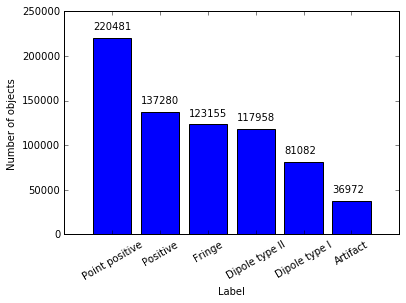

In [318]:
import collections
from operator import itemgetter
import matplotlib.pyplot as plt
%matplotlib inline

objects = {}

#classification = res[0]
for classification in cs:
    if isinstance(classification[0], str) == False:
        for label, src, visit in classification:
            if label in objects:
                objects[label] += 1
            else:
                objects[label] = 1

o_objects = collections.OrderedDict(sorted(objects.items(), key=itemgetter(1), reverse=True))
print o_objects
X = np.arange(len(o_objects))

p = plt.bar(X, o_objects.values(), align='center')
plt.xticks(X, o_objects.keys(), rotation=30)

plt.xlabel("Label")
plt.ylabel("Number of objects")
for i, rect in enumerate(p):
    plt.text(rect.get_x(), rect.get_height()+10000, int(rect.get_height()))

plt.show()

In [276]:
classification

['836493-12']

In [403]:
import lsst.afw.table as afwTable

c1 = afwTable.SourceCatalog.readFits("catalogs/844493-14.fits")
c2 = afwTable.SourceCatalog.readFits("catalogs/844493-14.fits")

In [404]:
print c1[0].get("id")
print c2[0].get("id")
c1.extend(c2)

1
1


In [405]:
s = c1[66]
print s['classification_dipole']

3.0


In [346]:
print s['parent']

0


In [347]:
sch = s.schema

In [348]:
sch.addField("extended-id", "F")

Key<F>(offset=464, nElements=1)

In [366]:
c1.schema.addField("extended-id", "F")

Key<F>(offset=464, nElements=1)

In [367]:
s = c1[66]
c1.schema

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['F'](name="classification_dipole", doc="probability of being a dipole"), Key<F>(offset=32, nElements=1)),
    (Field['Flag'](name="ip_diffim_NaiveDipoleCentroid_flag", doc="general failure flag, set if anything went wrong"), Key['Flag'](offset=40, bit=0)),
    (Field['Flag'](name="ip_diffim_NaiveDipoleCentroid_pos_flag", doc="failure flag for positive, set if anything went wrong"), Key['Flag'](offset=40, bit=1)),
    (Field['Flag'](name="ip_diffim_NaiveDipoleCentroid_neg_flag", doc="failure flag for negative, set if anything went wrong"), Key['Flag'](offset=40, bit=2)),
    (Field['D'](name="ip_d

In [359]:
print s["classification_dipole"]

1.0
